In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

In [37]:
dataset_1 = pd.read_csv("dataset_1.csv")
dataset_2 = pd.read_csv("dataset_2.csv")
dataset_3 = pd.read_csv("dataset_3.csv")
dataset_4 = pd.read_csv("dataset_4.csv")
dataset_5 = pd.read_csv("dataset_5.csv")
dataset_6 = pd.read_csv("dataset_6.csv")
datasets = [dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6]

## Exploratory Data Analysis

### Scatterplot

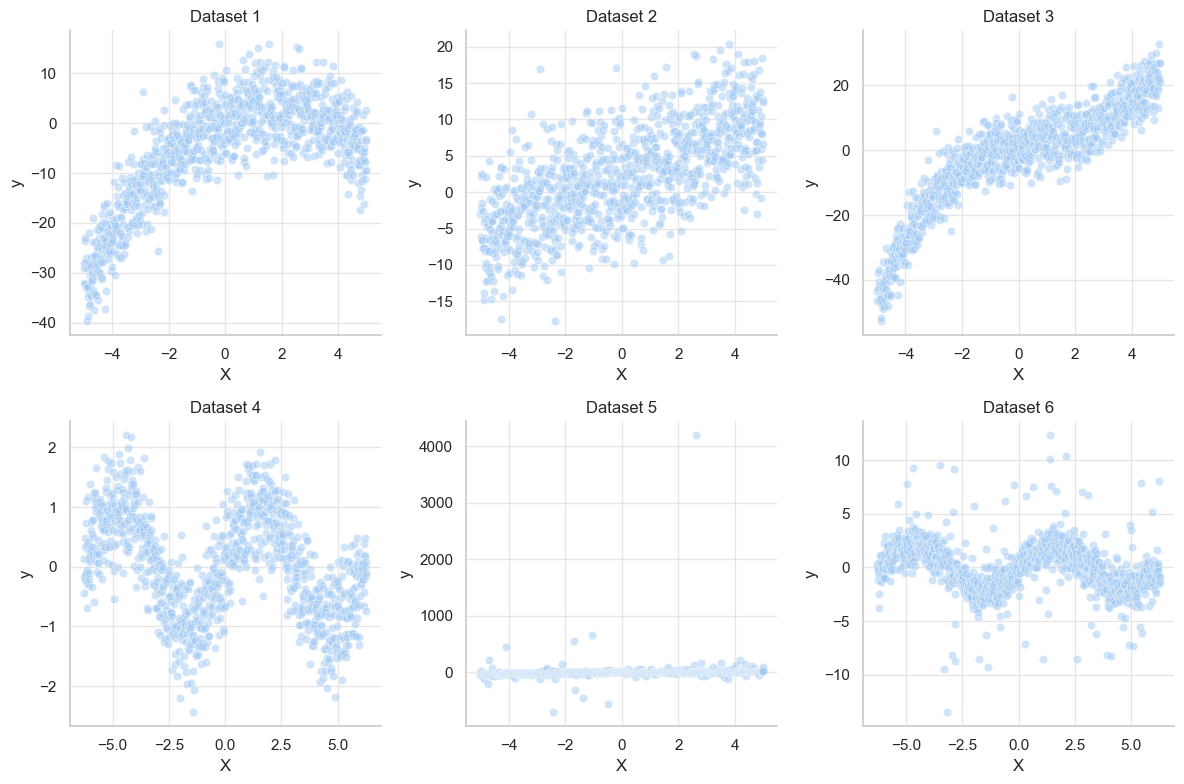

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.flatten()

# Aplicar el estilo aesthetic con colores pastel y cuadrícula más clara
sns.set(style="whitegrid", palette="pastel", rc={"grid.color": ".9"})

for i, (ax, data) in enumerate(zip(axes, datasets)):
    sns.scatterplot(x="X", y="y", data=data, ax=ax, alpha=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_title(f"Dataset {i + 1}")

# Remove the top and right spines from plot(s)
sns.despine()

plt.tight_layout()
plt.show()

## 10-Fold Cross Validation

In [94]:
def train_valid_mse_per_degree(dataset: pd.DataFrame, degree: int) -> dict:
    mse_dict_per_degree = {"mse_train": [], "mse_valid": []}

    # Split the dataset into 10 folds
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(dataset):
        train_set = dataset.iloc[train_index]
        val_set = dataset.iloc[val_index]

        X_train = train_set[["X"]]  # `PolynomialFeatures` needs a 2D array
        y_train = train_set["y"]

        X_val = val_set[["X"]]  # `PolynomialFeatures` needs a 2D array
        y_val = val_set["y"]

        # Transform features into polynomical
        # sklearn `PolynomialFeatures`` will add a column of ones to the dataset (intercept)
        # Therefore, it's not needed to add constant with `sm.add_constant()`
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Train on the training set
        model = sm.OLS(y_train, X_train_poly).fit()

        # Predict on the train set
        y_train_pred = model.predict(X_train_poly)

        # Predict on the validation set
        y_val_pred = model.predict(X_val_poly)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_valid = mean_squared_error(y_val, y_val_pred)
        mse_dict_per_degree["mse_train"].append(mse_train)
        mse_dict_per_degree["mse_valid"].append(mse_valid)

    return mse_dict_per_degree

In [103]:
def train_valid_mse(degrees: list[int], datasets: list[pd.DataFrame]):
    mse_per_dataset_dict = {
        f"dataset_{i + 1}": {"mse_train": [], "mse_valid": []}
        for i in range(len(datasets))
    }
    for i, dataset in tqdm(enumerate(datasets), desc="Datasets", total=len(datasets)):
        mean_mse_train_list = []
        mean_mse_valid_list = []

        for d in degrees:
            mse_dict = train_valid_mse_per_degree(dataset, d)
            mean_mse_train_list.append(np.mean(mse_dict["mse_train"]))
            mean_mse_valid_list.append(np.mean(mse_dict["mse_valid"]))

            mse_per_dataset_dict[f"dataset_{i + 1}"]["mse_train"] = mean_mse_train_list
            mse_per_dataset_dict[f"dataset_{i + 1}"]["mse_valid"] = mean_mse_valid_list

    return mse_per_dataset_dict

In [105]:
mse_per_dataset_dict = train_valid_mse(degrees=range(1, 16), datasets=datasets)

Datasets: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


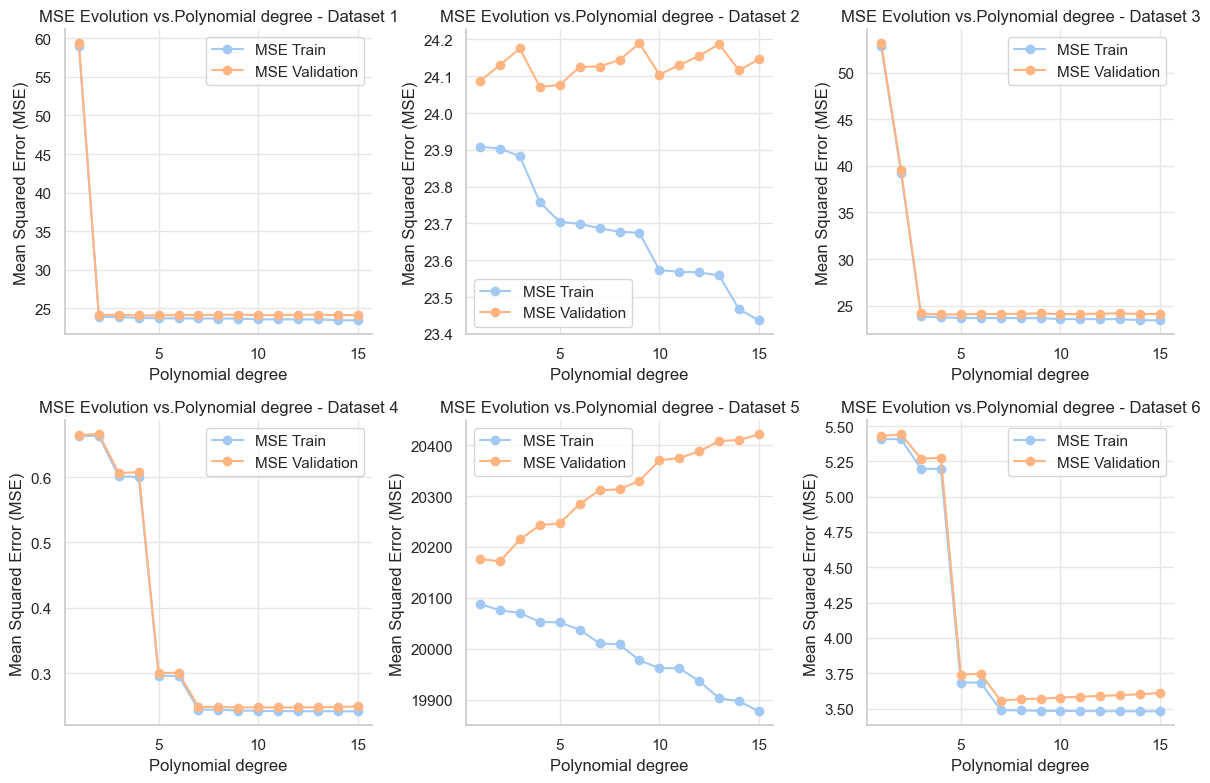

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.flatten()

for i, (ax, dataset) in enumerate(zip(axes, mse_per_dataset_dict)):
    ax.plot(
        range(1, 16),  # Degrees
        mse_per_dataset_dict[dataset]["mse_train"],
        marker="o",
        label="MSE Train",
    )
    ax.plot(
        range(1, 16),  # Degrees
        mse_per_dataset_dict[dataset]["mse_valid"],
        marker="o",
        label="MSE Validation",
    )
    ax.set_xlabel("Polynomial degree")
    ax.set_ylabel("Mean Squared Error (MSE)")
    ax.set_title(f"MSE Evolution vs.Polynomial degree - Dataset {i + 1}")
    ax.legend()

# Remove the top and right spines from plot(s)
sns.despine()

plt.tight_layout()
plt.show()